# ASRR Messy Data Challenge
## Example analysis (Python version)

In [ ]:
import pandas as pd


## Data exploration

### Read in data

In [2]:
df <- read_dta("../data/icu_data.dta")
head(df)

age,gender,iculos,hr,temp,sbp,dbp,resp,o2sat,map,sepsislabel,hospid,patid
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
65.36,0,28,71.0,38.11,168.00,56.0,17,94.0,91.0,0,A,3412
55.00,0,7,76.0,37.50,133.00,74.0,24,96.0,99.0,0,B,29564
38.00,0,15,77.0,NA,146.00,83.0,17,NA,108.0,0,B,31553
72.17,1,34,53.5,NA,157.00,60.5,15,95.5,92.5,0,A,7043
61.26,1,2,72.5,NA,93.25,68.5,18,100.0,79.0,0,A,8061
21.00,1,19,74.0,NA,118.00,104.0,20,91.0,112.0,0,B,25479


### What's in the dataset

In [3]:
summary(df)

      age             gender           iculos             hr        
 Min.   : 14.00   Min.   :0.0000   Min.   :  1.00   Min.   : 20.00  
 1st Qu.: 51.00   1st Qu.:0.0000   1st Qu.: 10.00   1st Qu.: 72.00  
 Median : 63.44   Median :1.0000   Median : 21.00   Median : 83.00  
 Mean   : 61.74   Mean   :0.5485   Mean   : 26.18   Mean   : 84.23  
 3rd Qu.: 74.00   3rd Qu.:1.0000   3rd Qu.: 34.00   3rd Qu.: 95.50  
 Max.   :100.00   Max.   :1.0000   Max.   :336.00   Max.   :223.00  
                                                    NA's   :131167  
      temp             sbp              dbp              resp       
 Min.   :20.9     Min.   : 20.0    Min.   : 20      Min.   :  1.00  
 1st Qu.:36.5     1st Qu.:107.0    1st Qu.: 55      1st Qu.: 16.00  
 Median :36.9     Median :122.0    Median : 63      Median : 18.00  
 Mean   :36.9     Mean   :124.7    Mean   : 65      Mean   : 18.73  
 3rd Qu.:37.4     3rd Qu.:140.0    3rd Qu.: 73      3rd Qu.: 21.00  
 Max.   :50.0     Max.   :298.0   

### Distributions of each of the variables

In [4]:
options(width = 110)
skim(df)

── Data Summary ────────────────────────
                           Values 
Name                       df     
Number of rows             1201974
Number of columns          13     
_______________________           
Column type frequency:            
  character                1      
  numeric                  12     
________________________          
Group variables            None   

── Variable type: character ──────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
1 hospid                0             1     1     1     0        2          0

── Variable type: numeric ────────────────────────────────────────────────────────────────────────────────────
   skim_variable n_missing complete_rate        mean         sd    p0     p25     p50     p75  p100 hist 
 1 age                   0         1        61.7        16.5     14      51      63.4    74     100 ▁▃▇▇▂
 2 gender        

### Complete case indicator

In [5]:
cols <- c("o2sat", "hr", "temp", "sbp", "map", "resp")
df <- df %>% 
    mutate(nvar_miss = rowSums(across(all_of(cols), is.na)),
           cc_fl = ifelse(nvar_miss == 0, TRUE, FALSE))

In [6]:
tabyl(df, cc_fl)

cc_fl,n,percent
<lgl>,<int>,<dbl>
FALSE,865835,0.7203442
TRUE,336139,0.2796558


Only 28% of records have no missing vital signs

## Outcome exploration

### How many people were diagnosed with sepsis?

In [7]:
df %>% 
    group_by(patid) %>% 
    summarise(any_sepsis = max(sepsislabel)) %>%
    tabyl(any_sepsis)

any_sepsis,n,percent
<dbl>,<int>,<dbl>
0,29268,0.94641876
1,1657,0.05358124


### When do people get sepsis in ICU?

In [8]:
df_sepsis <- df %>%
    filter(sepsislabel == 1) %>% 
    group_by(patid) %>%
    summarise(time_to_sepsis = min(iculos))
skim(df_sepsis, time_to_sepsis)

── Data Summary ────────────────────────
                           Values   
Name                       df_sepsis
Number of rows             1657     
Number of columns          2        
_______________________             
Column type frequency:              
  numeric                  1        
________________________            
Group variables            None     

── Variable type: numeric ────────────────────────────────────────────────────────────────────────────────────
  skim_variable  n_missing complete_rate  mean    sd    p0   p25   p50   p75  p100 hist 
1 time_to_sepsis         0             1  65.7  60.9     7    20    45    91   331 ▇▃▁▁▁


* min: 7 hours
* max: 331 hours (13.8 days)
* median: 45 hours

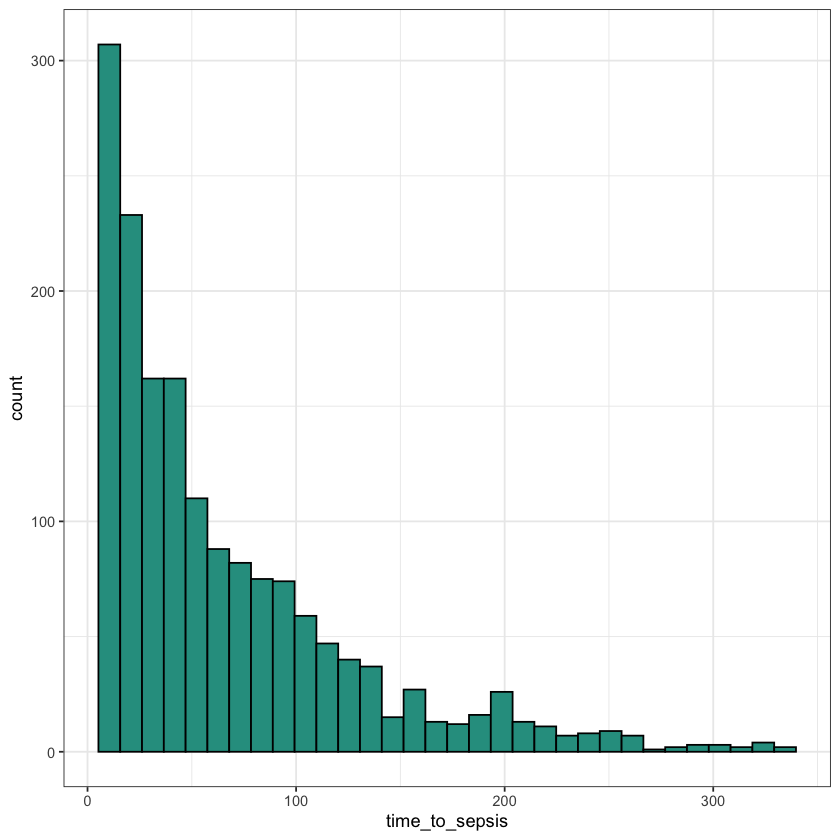

In [9]:
ggplot(df_sepsis, aes(x = time_to_sepsis)) +
    theme_bw() +
    geom_histogram(fill = "#2a9d8f", colour = "black", bins = 32)

### Create indicator for patient who get sepsis:

In [10]:
df <- df %>% 
    group_by(patid) %>% 
    mutate(any_sepsis = max(sepsislabel, na.rm = TRUE))

## Imputing explanatory measures

### Mean Imputation

In [12]:
impute_mean <- function(x) replace_na(x, mean(x, na.rm=T))
# Use only ICULOS <= 5
df_imp <- df %>% 
    filter(iculos <= 5) %>% 
    group_by(patid) %>% 
    arrange(patid, iculos) %>% 
    mutate(across(all_of(cols), impute_mean, .names = "{.col}_imp1"))
    

### First observation carried backwards

In [13]:
df_imp <- df_imp %>% 
    mutate(across(all_of(cols), ~.x, .names = "{.col}_imp2")) %>% 
    fill(ends_with("_imp2"), .direction = "up")

head(df_imp)

age,gender,iculos,hr,temp,sbp,dbp,resp,o2sat,map,⋯,temp_imp1,sbp_imp1,map_imp1,resp_imp1,o2sat_imp2,hr_imp2,temp_imp2,sbp_imp2,map_imp2,resp_imp2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
83.14,0,1,NA,NA,NA,NA,NA,NA,NA,⋯,NaN,114,84.22,23.875,95.0,97,NA,98,75.33,19.0
83.14,0,2,97,NA,98,NA,19.0,95.0,75.33,⋯,NaN,98,75.33,19.000,95.0,97,NA,98,75.33,19.0
83.14,0,3,89,NA,122,NA,22.0,99.0,86.00,⋯,NaN,122,86.00,22.000,99.0,89,NA,122,86.00,22.0
83.14,0,4,90,NA,NA,NA,30.0,95.0,NA,⋯,NaN,114,84.22,30.000,95.0,90,NA,122,91.33,30.0
83.14,0,5,103,NA,122,NA,24.5,88.5,91.33,⋯,NaN,122,91.33,24.500,88.5,103,NA,122,91.33,24.5
75.91,0,1,NA,NA,NA,NA,NA,NA,NA,⋯,36.44,123,65.25,19.125,99.0,61,36.44,124,65.00,17.5


### Inspect missingness again among imputed variables

In [14]:
df_imp <- df_imp %>%
    ungroup() %>% 
    mutate(nvar_miss_imp1 = rowSums(across(ends_with("_imp1"), is.na)),
           nvar_miss_imp2 = rowSums(across(ends_with("_imp2"), is.na)),
           cc_fl_imp1 = ifelse(nvar_miss_imp1 == 0, TRUE, FALSE),
           cc_fl_imp2 = ifelse(nvar_miss_imp2 == 0, TRUE, FALSE))

In [15]:
df_imp %>% 
    filter(iculos == 1) %>% 
    tabyl(cc_fl_imp1)

cc_fl_imp1,n,percent
<lgl>,<int>,<dbl>
FALSE,6897,0.2230234
TRUE,24028,0.7769766


In [16]:
df_imp %>% 
    filter(iculos == 1) %>% 
    tabyl(cc_fl_imp2)

cc_fl_imp2,n,percent
<lgl>,<int>,<dbl>
FALSE,6897,0.2230234
TRUE,24028,0.7769766


78% of rows non-missing for each imputation method

## Modelling

### Dummy indicators for hospital:
In R, dummy indicators for a binary / categorical (a.k.a factor) variable
will be created automatically when creating a formula object
to be used in generalised-linear model with `glm()`.

However, a no-intercept model is needed when fitting the regression
to avoid multicollinearity issue due to singular matrix.
For more discussion, see: https://stats.stackexchange.com/a/94021

### Mean imputation

In [17]:
model_imp1 <- glm(
    # the -1 term will suppress intercept, which is needed to avoid singularity matrix issue
    any_sepsis ~ -1 + age + gender + o2sat_imp1 + hr_imp1 + temp_imp1
                 + sbp_imp1 + map_imp1 + resp_imp1 + factor(hospid),
    data = filter(df_imp, iculos == 1),
    family = binomial(link = "logit")
)

In [18]:
summary(model_imp1)


Call:
glm(formula = any_sepsis ~ -1 + age + gender + o2sat_imp1 + hr_imp1 + 
    temp_imp1 + sbp_imp1 + map_imp1 + resp_imp1 + factor(hospid), 
    family = binomial(link = "logit"), data = filter(df_imp, 
        iculos == 1))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0167  -0.3480  -0.2962  -0.2514   2.9621  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
age              0.001538   0.001873   0.821  0.41162    
gender           0.182319   0.060440   3.017  0.00256 ** 
o2sat_imp1       0.014192   0.011535   1.230  0.21855    
hr_imp1          0.011620   0.001835   6.334 2.39e-10 ***
temp_imp1        0.007815   0.040582   0.193  0.84730    
sbp_imp1         0.002920   0.002554   1.143  0.25302    
map_imp1        -0.016736   0.003827  -4.373 1.23e-05 ***
resp_imp1        0.050361   0.006298   7.996 1.29e-15 ***
factor(hospid)A -5.496563   1.878954  -2.925  0.00344 ** 
factor(hospid)B -5.923873   1.876972  -3.156  0.00160 ** 
---


In [19]:
# Calculate odds ratio & 95% confidence interval
exp(coefficients(model_imp1)) %>%
    enframe(name = "variable", value = "odds ratio") %>%
    add_column(as_tibble(exp(confint(model_imp1))))

Waiting for profiling to be done...



variable,odds ratio,2.5 %,97.5 %
<chr>,<dbl>,<dbl>,<dbl>
age,1.00153917,9.978819e-01,1.0052367
gender,1.19999753,1.066285e+00,1.3514246
o2sat_imp1,1.01429313,9.925303e-01,1.0383737
hr_imp1,1.01168795,1.008049e+00,1.0153248
temp_imp1,1.00784512,9.309287e-01,1.0914074
sbp_imp1,1.00292389,9.978885e-01,1.0079298
map_imp1,0.98340323,9.760605e-01,0.9908138
resp_imp1,1.05165073,1.038685e+00,1.0646521
factor(hospid)A,0.00410084,9.841101e-05,0.1554736


#### First observation carried backwards

In [20]:
model_imp2 <- glm(
    # the -1 term will suppress intercept, which is needed to avoid singularity matrix issue
    any_sepsis ~ -1 + age + gender + o2sat_imp2 + hr_imp2 + temp_imp2
                 + sbp_imp2 + map_imp2 + resp_imp2 + factor(hospid),
    data = filter(df_imp, iculos == 1),
    family = binomial(link = "logit")
)

In [21]:
summary(model_imp2)


Call:
glm(formula = any_sepsis ~ -1 + age + gender + o2sat_imp2 + hr_imp2 + 
    temp_imp2 + sbp_imp2 + map_imp2 + resp_imp2 + factor(hospid), 
    family = binomial(link = "logit"), data = filter(df_imp, 
        iculos == 1))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1188  -0.3487  -0.2969  -0.2530   2.9213  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
age              0.002011   0.001858   1.083 0.278993    
gender           0.179775   0.060351   2.979 0.002894 ** 
o2sat_imp2      -0.003505   0.008713  -0.402 0.687495    
hr_imp2          0.011096   0.001669   6.647 2.98e-11 ***
temp_imp2        0.036431   0.038238   0.953 0.340720    
sbp_imp2         0.001067   0.002164   0.493 0.622103    
map_imp2        -0.012117   0.003177  -3.814 0.000137 ***
resp_imp2        0.034078   0.005201   6.552 5.69e-11 ***
factor(hospid)A -4.629805   1.652233  -2.802 0.005076 ** 
factor(hospid)B -5.080070   1.648675  -3.081 0.002061 ** 
---


In [22]:
# Calculate odds ratio & 95% confidence interval
exp(coefficients(model_imp2)) %>%
    enframe(name = "variable", value = "odds ratio") %>%
    add_column(as_tibble(exp(confint(model_imp2))))

Waiting for profiling to be done...



variable,odds ratio,2.5 %,97.5 %
<chr>,<dbl>,<dbl>,<dbl>
age,1.002013075,0.9983839947,1.0056812
gender,1.196947746,1.0637620110,1.3477559
o2sat_imp2,0.996501380,0.9804169530,1.0145076
hr_imp2,1.011157302,1.0078466742,1.0144630
temp_imp2,1.037102407,0.9623432758,1.1179221
sbp_imp2,1.001067178,0.9968119421,1.0053017
map_imp2,0.987955994,0.9818196556,0.9941161
resp_imp2,1.034665510,1.0240921583,1.0452040
factor(hospid)A,0.009756666,0.0003699473,0.2408788


### Higher respiration rate among those with sepsis?

In [23]:
df_imp %>% 
    group_by(any_sepsis) %>% 
    skim(resp_imp1)

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             154625    
Number of columns          32        
_______________________              
Column type frequency:               
  numeric                  1         
________________________             
Group variables            any_sepsis

── Variable type: numeric ────────────────────────────────────────────────────────────────────────────────────
  skim_variable any_sepsis n_missing complete_rate  mean    sd    p0   p25   p50   p75  p100 hist 
1 resp_imp1              0      4800         0.967  18.2  4.92     1  15      18  20.5    98 ▇▃▁▁▁
2 resp_imp1              1       340         0.959  19.6  5.98     1  15.6    19  22.7    53 ▁▇▃▁▁


In [25]:
df_imp %>% 
    group_by(any_sepsis) %>% 
    skim(resp_imp2)

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             154625    
Number of columns          32        
_______________________              
Column type frequency:               
  numeric                  1         
________________________             
Group variables            any_sepsis

── Variable type: numeric ────────────────────────────────────────────────────────────────────────────────────
  skim_variable any_sepsis n_missing complete_rate  mean    sd    p0   p25   p50   p75  p100 hist 
1 resp_imp2              0      9236         0.937  18.2  5.09     1  15      18    21    98 ▇▃▁▁▁
2 resp_imp2              1       553         0.933  19.6  6.07     1  15.5    19    23    53 ▁▇▃▁▁
